In [1]:
# Data Cleansing Notebook
# Analyze and clean the prepared images dataset for ankle alignment classification

import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import hashlib
from scipy import stats

# Set style for visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Paths
DATA_PATH = Path("../data")
IMAGES_PATH = DATA_PATH / "prepared_images"
PROPERTIES_FILE = DATA_PATH / "image_properties.csv"

print(f"Data path: {DATA_PATH.absolute()}")
print(f"Images path: {IMAGES_PATH.absolute()}")
print(f"Properties file exists: {PROPERTIES_FILE.exists()}")


Data path: d:\src\repos\ankle-align\notebook\..\data
Images path: d:\src\repos\ankle-align\notebook\..\data\prepared_images
Properties file exists: True


## 1. Load and Explore Data

Load the image properties CSV and perform initial exploration.


In [2]:
# Load image properties
df = pd.read_csv(PROPERTIES_FILE)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nData types:")
print(df.dtypes)

df.head(10)


Dataset shape: (326, 8)

Columns: ['width', 'height', 'aspect_ratio', 'pixels', 'mode', 'file_size_kb', 'filename', 'label']

Data types:
width             int64
height            int64
aspect_ratio    float64
pixels            int64
mode             object
file_size_kb    float64
filename         object
label            object
dtype: object


,width,height,aspect_ratio,pixels,mode,file_size_kb,filename,label
0,244,207,1.178744,50508,RGB,31.967773,B8V41Y_internet_actualne_01.png,Pronation
1,280,180,1.555556,50400,RGB,35.753906,B8V41Y_internet_algeos_01.png,Neutral
2,275,183,1.502732,50325,RGB,34.482422,B8V41Y_internet_everypixel_01.png,Pronation
3,275,183,1.502732,50325,RGB,24.750977,B8V41Y_internet_facebook_01.png,Pronation
4,275,183,1.502732,50325,RGB,26.961914,B8V41Y_internet_freepic_02.png,Pronation
5,170,296,0.574324,50320,RGB,35.907227,B8V41Y_internet_freepic_03.png,Neutral
6,275,183,1.502732,50325,RGB,38.078125,B8V41Y_internet_freepik_01.png,Neutral
7,275,183,1.502732,50325,RGB,33.645508,B8V41Y_internet_learnmuscles_01.png,Pronation
8,275,183,1.502732,50325,RGB,28.288086,B8V41Y_internet_shutterstock_01.png,Neutral
9,265,190,1.394737,50350,RGB,36.734375,B8V41Y_internet_shutterstock_02.png,Neutral


In [3]:
# Basic statistics
print("Numerical Statistics:")
print("=" * 70)
df.describe()


Numerical Statistics:


,width,height,aspect_ratio,pixels,file_size_kb
count,326.000000,326.000000,326.000000,3.260000e+02,326.000000
mean,1739.380368,1684.650307,1.210625,4.669134e+06,3428.528329
std,1384.576479,1414.558873,0.366902,6.101415e+06,4846.740547
min,170.000000,148.000000,0.562500,3.363000e+04,22.911133
25%,638.500000,480.000000,0.750000,3.084952e+05,222.368164
50%,1280.000000,960.000000,1.333333,1.228800e+06,875.753906
75%,2736.000000,2892.000000,1.498397,9.980928e+06,7206.476318
max,7172.000000,4912.000000,2.296403,3.432519e+07,32033.468750


Label Distribution:
label
Neutral       140
Pronation     133
Supination     50
Unlabeled       3
Name: count, dtype: int64

Total images: 326


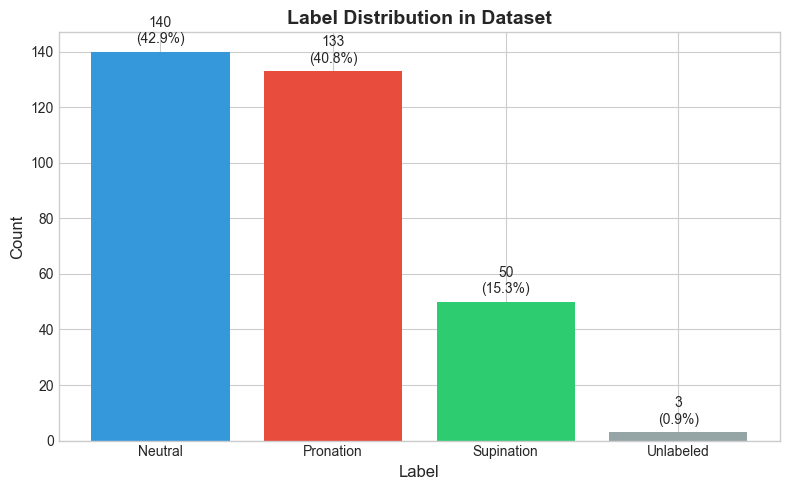

In [4]:
# Label distribution
print("Label Distribution:")
print("=" * 70)
label_counts = df['label'].value_counts()
print(label_counts)
print(f"\nTotal images: {len(df)}")

# Visualize label distribution
fig, ax = plt.subplots(figsize=(8, 5))
colors = {'Pronation': '#e74c3c', 'Neutral': '#3498db', 'Supination': '#2ecc71', 'Unlabeled': '#95a5a6'}
bars = ax.bar(label_counts.index, label_counts.values, 
              color=[colors.get(x, '#95a5a6') for x in label_counts.index])
ax.set_xlabel('Label', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Label Distribution in Dataset', fontsize=14, fontweight='bold')

for bar, count in zip(bars, label_counts.values):
    pct = count / len(df) * 100
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
            f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


## 2. Data Quality Checks

Perform comprehensive data quality analysis.


In [5]:
# Initialize quality report
quality_issues = []

print("DATA QUALITY REPORT")
print("=" * 70)

# 2.1 Check for missing values
print("\n1. MISSING VALUES")
print("-" * 40)
missing = df.isnull().sum()
if missing.sum() > 0:
    print("Columns with missing values:")
    print(missing[missing > 0])
    for col, count in missing[missing > 0].items():
        quality_issues.append({
            'issue_type': 'Missing Value',
            'column': col,
            'count': count,
            'details': f'{count} missing values in {col}'
        })
else:
    print("✓ No missing values found")

# 2.2 Check for unlabeled images
print("\n2. UNLABELED IMAGES")
print("-" * 40)
unlabeled = df[df['label'] == 'Unlabeled']
if len(unlabeled) > 0:
    print(f"⚠️ Found {len(unlabeled)} unlabeled images:")
    for _, row in unlabeled.iterrows():
        print(f"  - {row['filename']}")
        quality_issues.append({
            'issue_type': 'Unlabeled',
            'column': 'label',
            'count': 1,
            'details': row['filename'],
            'filename': row['filename']
        })
else:
    print("✓ All images are labeled")

# 2.3 Check for duplicate filenames
print("\n3. DUPLICATE FILENAMES")
print("-" * 40)
duplicates = df[df.duplicated(subset=['filename'], keep=False)]
if len(duplicates) > 0:
    print(f"⚠️ Found {len(duplicates)} duplicate filenames:")
    print(duplicates['filename'].value_counts())
    for fname in duplicates['filename'].unique():
        quality_issues.append({
            'issue_type': 'Duplicate Filename',
            'column': 'filename',
            'count': df[df['filename'] == fname].shape[0],
            'details': fname,
            'filename': fname
        })
else:
    print("✓ No duplicate filenames found")


DATA QUALITY REPORT

1. MISSING VALUES
----------------------------------------
✓ No missing values found

2. UNLABELED IMAGES
----------------------------------------
⚠️ Found 3 unlabeled images:
  - ITWQ3V_sajat_reszvevo01_02.png
  - ODZF0M_17.png
  - XV0M8Z_sajat_resztvevo07_01.png

3. DUPLICATE FILENAMES
----------------------------------------
✓ No duplicate filenames found


In [6]:
# 2.4 Check for invalid image modes
print("4. IMAGE MODE VALIDATION")
print("-" * 40)
valid_modes = ['RGB', 'L', 'RGBA', 'P']
invalid_modes = df[~df['mode'].isin(valid_modes)]
if len(invalid_modes) > 0:
    print(f"⚠️ Found {len(invalid_modes)} images with unexpected modes:")
    print(invalid_modes[['filename', 'mode']])
else:
    print("✓ All images have valid modes")

mode_counts = df['mode'].value_counts()
print(f"\nMode distribution:")
print(mode_counts)

# 2.5 Check for zero or negative dimensions
print("\n5. DIMENSION VALIDATION")
print("-" * 40)
invalid_dims = df[(df['width'] <= 0) | (df['height'] <= 0)]
if len(invalid_dims) > 0:
    print(f"⚠️ Found {len(invalid_dims)} images with invalid dimensions:")
    print(invalid_dims[['filename', 'width', 'height']])
else:
    print("✓ All images have valid dimensions")


4. IMAGE MODE VALIDATION
----------------------------------------
✓ All images have valid modes

Mode distribution:
mode
RGB    326
Name: count, dtype: int64

5. DIMENSION VALIDATION
----------------------------------------
✓ All images have valid dimensions


## 3. Image Dimension Analysis

Analyze image dimensions to identify outliers and inconsistencies.


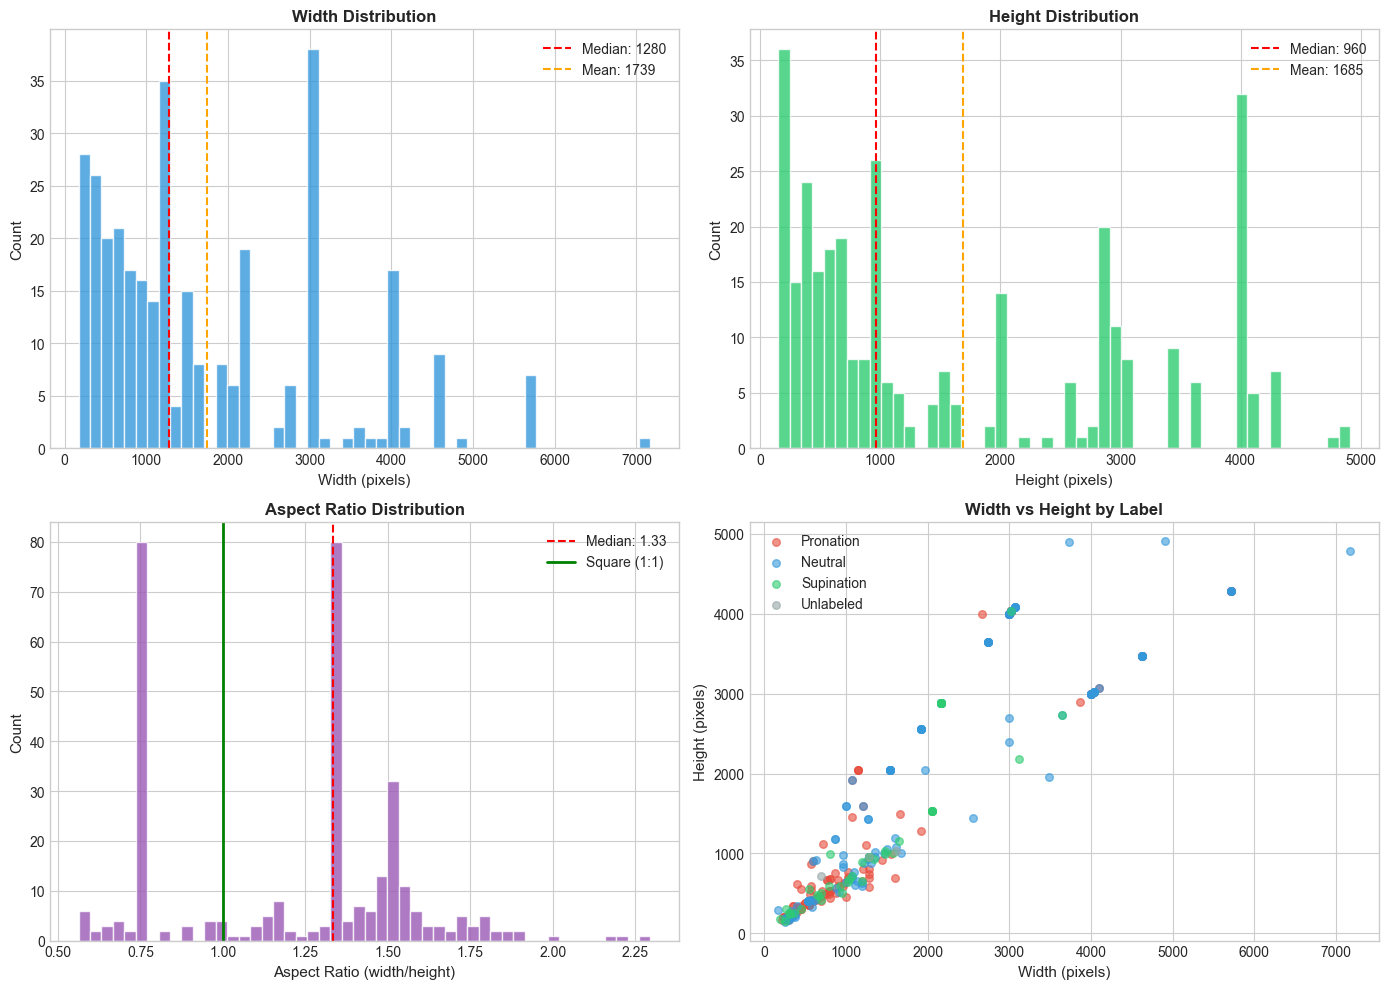

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Width distribution
ax1 = axes[0, 0]
ax1.hist(df['width'], bins=50, color='#3498db', edgecolor='white', alpha=0.8)
ax1.axvline(df['width'].median(), color='red', linestyle='--', label=f'Median: {df["width"].median():.0f}')
ax1.axvline(df['width'].mean(), color='orange', linestyle='--', label=f'Mean: {df["width"].mean():.0f}')
ax1.set_xlabel('Width (pixels)', fontsize=11)
ax1.set_ylabel('Count', fontsize=11)
ax1.set_title('Width Distribution', fontsize=12, fontweight='bold')
ax1.legend()

# Height distribution
ax2 = axes[0, 1]
ax2.hist(df['height'], bins=50, color='#2ecc71', edgecolor='white', alpha=0.8)
ax2.axvline(df['height'].median(), color='red', linestyle='--', label=f'Median: {df["height"].median():.0f}')
ax2.axvline(df['height'].mean(), color='orange', linestyle='--', label=f'Mean: {df["height"].mean():.0f}')
ax2.set_xlabel('Height (pixels)', fontsize=11)
ax2.set_ylabel('Count', fontsize=11)
ax2.set_title('Height Distribution', fontsize=12, fontweight='bold')
ax2.legend()

# Aspect ratio distribution
ax3 = axes[1, 0]
ax3.hist(df['aspect_ratio'], bins=50, color='#9b59b6', edgecolor='white', alpha=0.8)
ax3.axvline(df['aspect_ratio'].median(), color='red', linestyle='--', label=f'Median: {df["aspect_ratio"].median():.2f}')
ax3.axvline(1.0, color='green', linestyle='-', linewidth=2, label='Square (1:1)')
ax3.set_xlabel('Aspect Ratio (width/height)', fontsize=11)
ax3.set_ylabel('Count', fontsize=11)
ax3.set_title('Aspect Ratio Distribution', fontsize=12, fontweight='bold')
ax3.legend()

# Width vs Height scatter
ax4 = axes[1, 1]
colors_scatter = {'Pronation': '#e74c3c', 'Neutral': '#3498db', 'Supination': '#2ecc71', 'Unlabeled': '#95a5a6'}
for label in df['label'].unique():
    subset = df[df['label'] == label]
    ax4.scatter(subset['width'], subset['height'], 
                c=colors_scatter.get(label, '#95a5a6'), label=label, alpha=0.6, s=30)
ax4.set_xlabel('Width (pixels)', fontsize=11)
ax4.set_ylabel('Height (pixels)', fontsize=11)
ax4.set_title('Width vs Height by Label', fontsize=12, fontweight='bold')
ax4.legend()

plt.tight_layout()
plt.show()


In [8]:
# Identify dimension outliers using IQR method
print("DIMENSION OUTLIER ANALYSIS")
print("=" * 70)

def find_outliers_iqr(data, column, multiplier=1.5):
    """Find outliers using IQR method."""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Width outliers
width_outliers, w_lower, w_upper = find_outliers_iqr(df, 'width')
print(f"\nWidth Outliers (bounds: {w_lower:.0f} - {w_upper:.0f}):")
print(f"  Found {len(width_outliers)} outliers")
if len(width_outliers) > 0:
    print(f"  Range: {width_outliers['width'].min():.0f} - {width_outliers['width'].max():.0f} pixels")

# Height outliers
height_outliers, h_lower, h_upper = find_outliers_iqr(df, 'height')
print(f"\nHeight Outliers (bounds: {h_lower:.0f} - {h_upper:.0f}):")
print(f"  Found {len(height_outliers)} outliers")
if len(height_outliers) > 0:
    print(f"  Range: {height_outliers['height'].min():.0f} - {height_outliers['height'].max():.0f} pixels")

# Pixel count outliers
pixel_outliers, p_lower, p_upper = find_outliers_iqr(df, 'pixels')
print(f"\nPixel Count Outliers (bounds: {p_lower:.0f} - {p_upper:.0f}):")
print(f"  Found {len(pixel_outliers)} outliers")


DIMENSION OUTLIER ANALYSIS

Width Outliers (bounds: -2508 - 5882):
  Found 1 outliers
  Range: 7172 - 7172 pixels

Height Outliers (bounds: -3138 - 6510):
  Found 0 outliers

Pixel Count Outliers (bounds: -14200154 - 24489577):
  Found 1 outliers


In [9]:
# Identify very small images that may need attention
print("SMALL IMAGE ANALYSIS")
print("-" * 40)

# Define thresholds for "small" images
MIN_WIDTH = 200
MIN_HEIGHT = 200
MIN_PIXELS = 50000

small_images = df[(df['width'] < MIN_WIDTH) | (df['height'] < MIN_HEIGHT) | (df['pixels'] < MIN_PIXELS)]
print(f"Images smaller than {MIN_WIDTH}x{MIN_HEIGHT} or {MIN_PIXELS:,} pixels: {len(small_images)}")

if len(small_images) > 0:
    print("\nSmall images:")
    for _, row in small_images.head(10).iterrows():
        print(f"  {row['filename']}: {row['width']}x{row['height']} = {row['pixels']:,} pixels")
        quality_issues.append({
            'issue_type': 'Small Image',
            'column': 'dimensions',
            'count': 1,
            'details': f"{row['width']}x{row['height']}",
            'filename': row['filename']
        })
    if len(small_images) > 10:
        print(f"  ... and {len(small_images) - 10} more")


SMALL IMAGE ANALYSIS
----------------------------------------
Images smaller than 200x200 or 50,000 pixels: 23

Small images:
  B8V41Y_internet_algeos_01.png: 280x180 = 50,400 pixels
  B8V41Y_internet_everypixel_01.png: 275x183 = 50,325 pixels
  B8V41Y_internet_facebook_01.png: 275x183 = 50,325 pixels
  B8V41Y_internet_freepic_02.png: 275x183 = 50,325 pixels
  B8V41Y_internet_freepic_03.png: 170x296 = 50,320 pixels
  B8V41Y_internet_freepik_01.png: 275x183 = 50,325 pixels
  B8V41Y_internet_learnmuscles_01.png: 275x183 = 50,325 pixels
  B8V41Y_internet_shutterstock_01.png: 275x183 = 50,325 pixels
  B8V41Y_internet_shutterstock_02.png: 265x190 = 50,350 pixels
  B8V41Y_internet_shutterstock_03.png: 232x200 = 46,400 pixels
  ... and 13 more


In [10]:
# Identify very large images
print("LARGE IMAGE ANALYSIS")
print("-" * 40)

# Define thresholds for "large" images (may slow training)
MAX_PIXELS = 10000000  # 10 megapixels
MAX_SIZE_KB = 5000  # 5 MB

large_images = df[(df['pixels'] > MAX_PIXELS) | (df['file_size_kb'] > MAX_SIZE_KB)]
print(f"Images larger than {MAX_PIXELS/1e6:.0f} MP or {MAX_SIZE_KB/1000:.0f} MB: {len(large_images)}")

if len(large_images) > 0:
    print("\nLargest images by pixel count:")
    for _, row in large_images.nlargest(10, 'pixels').iterrows():
        mp = row['pixels'] / 1e6
        mb = row['file_size_kb'] / 1000
        print(f"  {row['filename']}: {row['width']}x{row['height']} = {mp:.1f} MP, {mb:.1f} MB")
        quality_issues.append({
            'issue_type': 'Large Image',
            'column': 'dimensions',
            'count': 1,
            'details': f"{mp:.1f} MP, {mb:.1f} MB",
            'filename': row['filename']
        })


LARGE IMAGE ANALYSIS
----------------------------------------
Images larger than 10 MP or 5 MB: 87

Largest images by pixel count:
  D6AE9F_internet_freepik_08.png: 7172x4786 = 34.3 MP, 32.0 MB
  C6037J_sajat_resztvevo01_03.png: 5712x4284 = 24.5 MP, 12.7 MB
  C6037J_sajat_resztvevo01_04.png: 5712x4284 = 24.5 MP, 10.3 MB
  C6037J_sajat_resztvevo02_01.png: 5712x4284 = 24.5 MP, 11.6 MB
  C6037J_sajat_resztvevo02_04.png: 5712x4284 = 24.5 MP, 13.0 MB
  C6037J_sajat_resztvevo03_01.png: 5712x4284 = 24.5 MP, 10.6 MB
  C6037J_sajat_resztvevo04_02.png: 5712x4284 = 24.5 MP, 13.0 MB
  C6037J_sajat_resztvevo04_03.png: 5712x4284 = 24.5 MP, 14.4 MB
  D6AE9F_internet_freepik_07.png: 4912x4912 = 24.1 MP, 18.9 MB
  D6AE9F_internet_freepik_09.png: 3728x4904 = 18.3 MP, 15.1 MB


## 4. File Size Analysis

Analyze file sizes and identify anomalies.


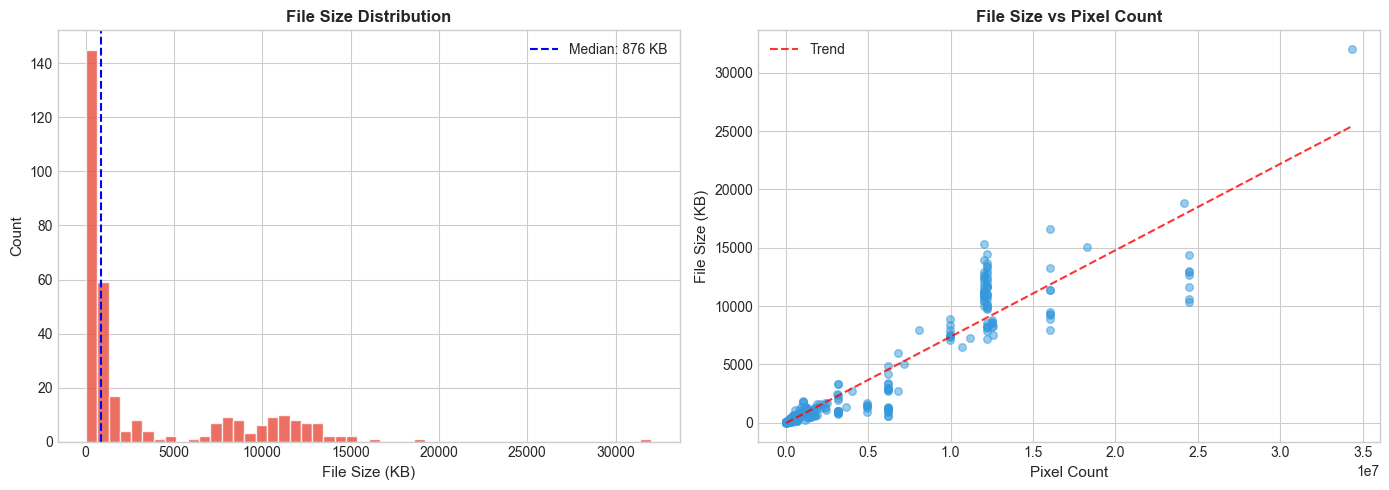


File Size Statistics:
  Total dataset size: 1091.5 MB
  Average file size: 3428.5 KB
  Median file size: 875.8 KB
  Min/Max: 22.9 KB / 32033.5 KB


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# File size distribution
ax1 = axes[0]
ax1.hist(df['file_size_kb'], bins=50, color='#e74c3c', edgecolor='white', alpha=0.8)
ax1.axvline(df['file_size_kb'].median(), color='blue', linestyle='--', 
            label=f'Median: {df["file_size_kb"].median():.0f} KB')
ax1.set_xlabel('File Size (KB)', fontsize=11)
ax1.set_ylabel('Count', fontsize=11)
ax1.set_title('File Size Distribution', fontsize=12, fontweight='bold')
ax1.legend()

# File size vs pixel count (compression efficiency)
ax2 = axes[1]
ax2.scatter(df['pixels'], df['file_size_kb'], alpha=0.5, c='#3498db', s=30)
ax2.set_xlabel('Pixel Count', fontsize=11)
ax2.set_ylabel('File Size (KB)', fontsize=11)
ax2.set_title('File Size vs Pixel Count', fontsize=12, fontweight='bold')

# Add trend line
z = np.polyfit(df['pixels'], df['file_size_kb'], 1)
p = np.poly1d(z)
x_line = np.linspace(df['pixels'].min(), df['pixels'].max(), 100)
ax2.plot(x_line, p(x_line), 'r--', alpha=0.8, label='Trend')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"\nFile Size Statistics:")
print(f"  Total dataset size: {df['file_size_kb'].sum() / 1024:.1f} MB")
print(f"  Average file size: {df['file_size_kb'].mean():.1f} KB")
print(f"  Median file size: {df['file_size_kb'].median():.1f} KB")
print(f"  Min/Max: {df['file_size_kb'].min():.1f} KB / {df['file_size_kb'].max():.1f} KB")


In [12]:
# Calculate compression ratio (bytes per pixel)
df['bytes_per_pixel'] = (df['file_size_kb'] * 1024) / df['pixels']

print("COMPRESSION ANALYSIS")
print("=" * 70)
print(f"\nBytes per pixel statistics:")
print(f"  Mean: {df['bytes_per_pixel'].mean():.3f}")
print(f"  Median: {df['bytes_per_pixel'].median():.3f}")
print(f"  Std: {df['bytes_per_pixel'].std():.3f}")

# Identify poorly compressed images (high bytes per pixel)
high_compression = df[df['bytes_per_pixel'] > df['bytes_per_pixel'].quantile(0.95)]
low_compression = df[df['bytes_per_pixel'] < df['bytes_per_pixel'].quantile(0.05)]

print(f"\nImages with unusually HIGH bytes/pixel (top 5%): {len(high_compression)}")
if len(high_compression) > 0:
    for _, row in high_compression.head(5).iterrows():
        print(f"  {row['filename']}: {row['bytes_per_pixel']:.3f} bytes/pixel")

print(f"\nImages with unusually LOW bytes/pixel (bottom 5%): {len(low_compression)}")
if len(low_compression) > 0:
    for _, row in low_compression.head(5).iterrows():
        print(f"  {row['filename']}: {row['bytes_per_pixel']:.3f} bytes/pixel")


COMPRESSION ANALYSIS

Bytes per pixel statistics:
  Mean: 0.790
  Median: 0.767
  Std: 0.340

Images with unusually HIGH bytes/pixel (top 5%): 17
  B8V41Y_sajat_resztvevo02_01.png: 1.525 bytes/pixel
  C6037J_internet_semmelweis_01.png: 1.481 bytes/pixel
  C6037J_internet_semmelweis_03.png: 1.401 bytes/pixel
  C6037J_internet_semmelweis_04.png: 1.476 bytes/pixel
  D6AE9F_internet_rheumexamatlas_03.png: 1.732 bytes/pixel

Images with unusually LOW bytes/pixel (bottom 5%): 17
  FO6K58_sajat_resztvevo01_02.png: 0.199 bytes/pixel
  FO6K58_sajat_resztvevo01_04.png: 0.258 bytes/pixel
  FO6K58_sajat_resztvevo03_01.png: 0.093 bytes/pixel
  FO6K58_sajat_resztvevo03_02.png: 0.092 bytes/pixel
  FO6K58_sajat_resztvevo03_03.png: 0.171 bytes/pixel


## 5. Duplicate Image Detection

Detect potential duplicate images based on file hash or similar properties.


In [13]:
def compute_image_hash(image_path):
    """Compute MD5 hash of image file."""
    try:
        with open(image_path, 'rb') as f:
            return hashlib.md5(f.read()).hexdigest()
    except Exception as e:
        return None

# Compute hashes for all images
print("Computing image hashes for duplicate detection...")
hashes = {}
for idx, row in df.iterrows():
    image_path = IMAGES_PATH / row['filename']
    if image_path.exists():
        file_hash = compute_image_hash(image_path)
        if file_hash:
            hashes[row['filename']] = file_hash

df['file_hash'] = df['filename'].map(hashes)
print(f"Computed hashes for {len(hashes)} images")


Computing image hashes for duplicate detection...
Computed hashes for 326 images


In [14]:
# Find exact duplicates by hash
print("EXACT DUPLICATE DETECTION (by file hash)")
print("=" * 70)

hash_counts = df['file_hash'].value_counts()
duplicate_hashes = hash_counts[hash_counts > 1]

if len(duplicate_hashes) > 0:
    print(f"⚠️ Found {len(duplicate_hashes)} sets of exact duplicate images:")
    for file_hash, count in duplicate_hashes.items():
        dup_files = df[df['file_hash'] == file_hash]['filename'].tolist()
        print(f"\n  Duplicate set ({count} files):")
        for f in dup_files:
            label = df[df['filename'] == f]['label'].values[0]
            print(f"    - {f} [{label}]")
            quality_issues.append({
                'issue_type': 'Exact Duplicate',
                'column': 'file_hash',
                'count': count,
                'details': f'Hash: {file_hash[:16]}...',
                'filename': f
            })
else:
    print("✓ No exact duplicate images found")


EXACT DUPLICATE DETECTION (by file hash)
⚠️ Found 11 sets of exact duplicate images:

  Duplicate set (5 files):
    - C6037J_internet_rheumexamatlas_01.png [Neutral]
    - D6AE9F_internet_rheumexamatlas_01.png [Neutral]
    - FGWUFP_internet_rheumexamatlas_02.png [Neutral]
    - FO6K58_internet_rheumexamatlas_02.png [Neutral]
    - GK1XQ4_internet_rmatakov_05.png [Pronation]

  Duplicate set (2 files):
    - C6037J_internet_semmelweis_02.png [Pronation]
    - GK1XQ4_internet_semmelweis_32.png [Pronation]

  Duplicate set (2 files):
    - C6037J_internet_semmelweis_03.png [Pronation]
    - GK1XQ4_internet_semmelweis_31.png [Pronation]

  Duplicate set (2 files):
    - FGWUFP_internet_dentonfootandanklesurgery_01.png [Pronation]
    - FO6K58_internet_dentonfootandanklesurgery_01.png [Pronation]

  Duplicate set (2 files):
    - FGWUFP_internet_rheumexamatlas_01.png [Pronation]
    - FO6K58_internet_rheumexamatlas_01.png [Pronation]

  Duplicate set (2 files):
    - FO6K58_ITWQ3V_sajat_r

In [15]:
# Find near-duplicates by similar properties
print("NEAR-DUPLICATE DETECTION (by properties)")
print("=" * 70)

# Group by exact dimensions and file size
df['property_signature'] = df['width'].astype(str) + 'x' + df['height'].astype(str) + '_' + df['file_size_kb'].round(2).astype(str)
property_counts = df['property_signature'].value_counts()
potential_duplicates = property_counts[property_counts > 1]

if len(potential_duplicates) > 0:
    print(f"Found {len(potential_duplicates)} sets of images with identical dimensions and file size:")
    for sig, count in potential_duplicates.head(10).items():
        matching = df[df['property_signature'] == sig][['filename', 'label']]
        if len(matching['label'].unique()) > 1:  # Different labels = potential issue
            print(f"\n  ⚠️ Same properties, DIFFERENT labels ({sig.split('_')[0]}):")
            for _, row in matching.iterrows():
                print(f"    - {row['filename']} [{row['label']}]")
else:
    print("✓ No images with identical property signatures found")


NEAR-DUPLICATE DETECTION (by properties)
Found 11 sets of images with identical dimensions and file size:

  ⚠️ Same properties, DIFFERENT labels (536x402):
    - C6037J_internet_rheumexamatlas_01.png [Neutral]
    - D6AE9F_internet_rheumexamatlas_01.png [Neutral]
    - FGWUFP_internet_rheumexamatlas_02.png [Neutral]
    - FO6K58_internet_rheumexamatlas_02.png [Neutral]
    - GK1XQ4_internet_rmatakov_05.png [Pronation]

  ⚠️ Same properties, DIFFERENT labels (1280x960):
    - FO6K58_ITWQ3V_sajat_reszvevo01_03.png [Supination]
    - ITWQ3V_sajat_reszvevo01_03.png [Pronation]

  ⚠️ Same properties, DIFFERENT labels (1280x960):
    - FO6K58_ITWQ3V_sajat_reszvevo01_01.png [Supination]
    - ITWQ3V_sajat_reszvevo01_01.png [Pronation]


Looks like everyone found the same images online, but labeled them differently. Interesting!

## 8. Quality Issues Summary

Compile all identified quality issues and provide recommendations.


In [16]:
# Create quality issues DataFrame
df_issues = pd.DataFrame(quality_issues)

print("QUALITY ISSUES SUMMARY")
print("=" * 70)

if len(df_issues) > 0:
    # Summary by issue type
    issue_summary = df_issues.groupby('issue_type').size().sort_values(ascending=False)
    print("\nIssues by type:")
    for issue_type, count in issue_summary.items():
        print(f"  {issue_type}: {count}")
    
    print(f"\nTotal issues found: {len(df_issues)}")
else:
    print("✓ No quality issues found!")


QUALITY ISSUES SUMMARY

Issues by type:
  Exact Duplicate: 25
  Large Image: 10
  Small Image: 10
  Unlabeled: 3

Total issues found: 48


In [17]:
# Detailed issues table
if len(df_issues) > 0:
    print("DETAILED ISSUES TABLE")
    print("=" * 70)
    display(df_issues.head(30))


DETAILED ISSUES TABLE


,issue_type,column,count,details,filename
0,Unlabeled,label,1,ITWQ3V_sajat_reszvevo01_02.png,ITWQ3V_sajat_reszvevo01_02.png
1,Unlabeled,label,1,ODZF0M_17.png,ODZF0M_17.png
2,Unlabeled,label,1,XV0M8Z_sajat_resztvevo07_01.png,XV0M8Z_sajat_resztvevo07_01.png
3,Small Image,dimensions,1,280x180,B8V41Y_internet_algeos_01.png
4,Small Image,dimensions,1,275x183,B8V41Y_internet_everypixel_01.png
5,Small Image,dimensions,1,275x183,B8V41Y_internet_facebook_01.png
6,Small Image,dimensions,1,275x183,B8V41Y_internet_freepic_02.png
7,Small Image,dimensions,1,170x296,B8V41Y_internet_freepic_03.png
8,Small Image,dimensions,1,275x183,B8V41Y_internet_freepik_01.png
9,Small Image,dimensions,1,275x183,B8V41Y_internet_learnmuscles_01.png


## 9. Recommendations

Based on the analysis, here are recommendations for data cleaning.


In [18]:
print("DATA CLEANING RECOMMENDATIONS")
print("=" * 70)

recommendations = []

# 1. Unlabeled images
n_unlabeled = len(df[df['label'] == 'Unlabeled'])
if n_unlabeled > 0:
    recommendations.append({
        'priority': 'HIGH',
        'category': 'Labels',
        'recommendation': f'Review and label {n_unlabeled} unlabeled images, or remove them from the dataset',
        'impact': 'Prevents training errors and ensures all data is usable'
    })

# 2. Duplicate images
if len(duplicate_hashes) > 0:
    recommendations.append({
        'priority': 'HIGH',
        'category': 'Duplicates',
        'recommendation': f'Remove {len(duplicate_hashes)} sets of exact duplicate images to prevent data leakage',
        'impact': 'Prevents overfitting and ensures fair train/test splits'
    })

# 3. Small images
n_small = len(small_images)
if n_small > 0:
    recommendations.append({
        'priority': 'MEDIUM',
        'category': 'Dimensions',
        'recommendation': f'Review {n_small} small images (<{MIN_WIDTH}x{MIN_HEIGHT}) for quality',
        'impact': 'Small images may not have enough detail for accurate classification'
    })

# 4. Large images
n_large = len(large_images)
if n_large > 0:
    recommendations.append({
        'priority': 'LOW',
        'category': 'Dimensions',
        'recommendation': f'Consider resizing {n_large} very large images (>{MAX_PIXELS/1e6:.0f}MP) to reduce memory usage',
        'impact': 'Reduces training time and memory requirements'
    })

# 5. Class imbalance
label_counts_clean = df['label'].value_counts()
if 'Unlabeled' in label_counts_clean.index:
    label_counts_clean = label_counts_clean.drop('Unlabeled')
if len(label_counts_clean) > 1:
    imbalance_ratio = label_counts_clean.max() / label_counts_clean.min()
    if imbalance_ratio > 3:
        recommendations.append({
            'priority': 'MEDIUM',
            'category': 'Class Balance',
            'recommendation': f'Address class imbalance (ratio {imbalance_ratio:.1f}:1) with oversampling, undersampling, or class weights',
            'impact': 'Improves model performance on minority classes'
        })

# 6. Standardize dimensions
recommendations.append({
    'priority': 'HIGH',
    'category': 'Preprocessing',
    'recommendation': 'Resize all images to a consistent size (e.g., 224x224, 256x256) for model training',
    'impact': 'Required for batch processing in neural networks'
})

# Print recommendations
df_recommendations = pd.DataFrame(recommendations)
df_recommendations = df_recommendations.sort_values('priority')

for _, rec in df_recommendations.iterrows():
    priority_symbol = {'HIGH': '🔴', 'MEDIUM': '🟡', 'LOW': '🟢'}[rec['priority']]
    print(f"\n{priority_symbol} [{rec['priority']}] {rec['category']}")
    print(f"   {rec['recommendation']}")
    print(f"   Impact: {rec['impact']}")


DATA CLEANING RECOMMENDATIONS

🔴 [HIGH] Labels
   Review and label 3 unlabeled images, or remove them from the dataset
   Impact: Prevents training errors and ensures all data is usable

🔴 [HIGH] Duplicates
   Remove 11 sets of exact duplicate images to prevent data leakage
   Impact: Prevents overfitting and ensures fair train/test splits

🔴 [HIGH] Preprocessing
   Resize all images to a consistent size (e.g., 224x224, 256x256) for model training
   Impact: Required for batch processing in neural networks

🟢 [LOW] Dimensions
   Consider resizing 87 very large images (>10MP) to reduce memory usage
   Impact: Reduces training time and memory requirements

🟡 [MEDIUM] Dimensions
   Review 23 small images (<200x200) for quality
   Impact: Small images may not have enough detail for accurate classification


## 10. Create Cleaned Dataset

Generate a cleaned version of the dataset based on the analysis.


In [19]:
# Create cleaned dataset
print("CREATING CLEANED DATASET")
print("=" * 70)

df_clean = df.copy()
initial_count = len(df_clean)

# 1. Remove unlabeled images
df_clean = df_clean[df_clean['label'] != 'Unlabeled']
after_unlabeled = len(df_clean)
print(f"1. Removed unlabeled images: {initial_count - after_unlabeled} removed, {after_unlabeled} remaining")

# 2. Remove exact duplicates (keep first occurrence)
df_clean = df_clean.drop_duplicates(subset=['file_hash'], keep='first')
after_duplicates = len(df_clean)
print(f"2. Removed exact duplicates: {after_unlabeled - after_duplicates} removed, {after_duplicates} remaining")

# 3. Flag but keep small and large images (user can decide)
df_clean['size_flag'] = 'Normal'
df_clean.loc[df_clean['pixels'] < MIN_PIXELS, 'size_flag'] = 'Small'
df_clean.loc[df_clean['pixels'] > MAX_PIXELS, 'size_flag'] = 'Large'

print(f"\nFlagged images by size:")
print(df_clean['size_flag'].value_counts())

print(f"\n" + "=" * 70)
print(f"FINAL CLEANED DATASET: {len(df_clean)} images")
print(f"Removed: {initial_count - len(df_clean)} images ({(initial_count - len(df_clean))/initial_count*100:.1f}%)")


CREATING CLEANED DATASET
1. Removed unlabeled images: 3 removed, 323 remaining
2. Removed exact duplicates: 13 removed, 310 remaining

Flagged images by size:
size_flag
Normal    228
Large      76
Small       6
Name: count, dtype: int64

FINAL CLEANED DATASET: 310 images
Removed: 16 images (4.9%)


CLEANED DATASET LABEL DISTRIBUTION
label
Neutral       137
Pronation     125
Supination     48
Name: count, dtype: int64


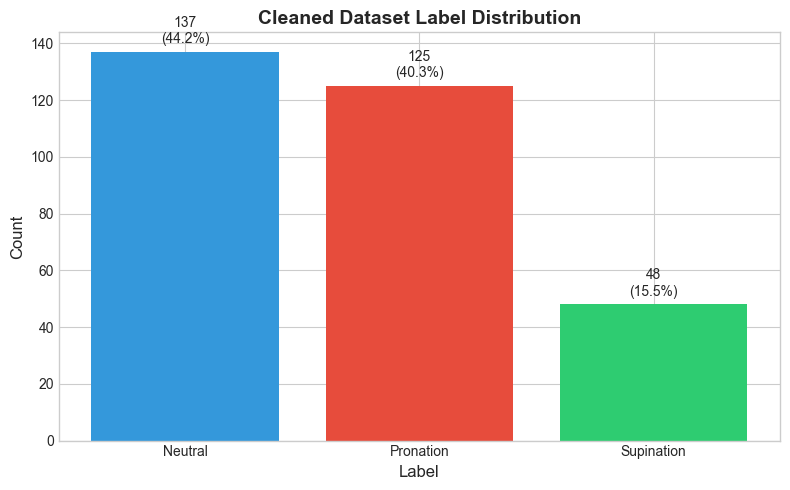

In [20]:
# Final label distribution
print("CLEANED DATASET LABEL DISTRIBUTION")
print("=" * 70)

clean_label_counts = df_clean['label'].value_counts()
print(clean_label_counts)

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(clean_label_counts.index, clean_label_counts.values,
              color=[colors.get(x, '#95a5a6') for x in clean_label_counts.index])
ax.set_xlabel('Label', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Cleaned Dataset Label Distribution', fontsize=14, fontweight='bold')

for bar, count in zip(bars, clean_label_counts.values):
    pct = count / len(df_clean) * 100
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
            f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [21]:
df_clean

,width,height,aspect_ratio,pixels,mode,file_size_kb,filename,label,bytes_per_pixel,file_hash,property_signature,size_flag
0,244,207,1.178744,50508,RGB,31.967773,B8V41Y_internet_actualne_01.png,Pronation,0.648115,2cb6d8deaec0d94d85e8d5288311598a,244x207_31.97,Normal
1,280,180,1.555556,50400,RGB,35.753906,B8V41Y_internet_algeos_01.png,Neutral,0.726429,aa3371268c9504cfd1b12a05977b7962,280x180_35.75,Normal
2,275,183,1.502732,50325,RGB,34.482422,B8V41Y_internet_everypixel_01.png,Pronation,0.701639,7ce9dce2bcaecf52e4a15223a562baa6,275x183_34.48,Normal
3,275,183,1.502732,50325,RGB,24.750977,B8V41Y_internet_facebook_01.png,Pronation,0.503626,9e58f618557b16218fa59841c909cd15,275x183_24.75,Normal
4,275,183,1.502732,50325,RGB,26.961914,B8V41Y_internet_freepic_02.png,Pronation,0.548614,30b7058ab06d842830537b3e08cd155b,275x183_26.96,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...
321,1501,1061,1.414703,1592561,RGB,1068.091797,XV0M8Z_sajat_resztvevo13_02.png,Neutral,0.686772,3e9ec9021044deae3e62a88ca50b6ab6,1501x1061_1068.09,Normal
322,1357,1015,1.336946,1377355,RGB,663.698242,XV0M8Z_sajat_resztvevo14_01.png,Neutral,0.493429,2f3ace0b55ef793382355c9acf2638be,1357x1015_663.7,Normal
323,1222,878,1.391800,1072916,RGB,766.282227,XV0M8Z_sajat_resztvevo14_02.png,Neutral,0.731346,909e853dbc3cd2b7590ea2e380b9127b,1222x878_766.28,Normal
324,874,564,1.549645,492936,RGB,422.886719,XV0M8Z_sajat_resztvevo14_03.png,Neutral,0.878483,7c4f4a4011528286702520177234d130,874x564_422.89,Normal


In [22]:
# Export cleaned dataset
OUTPUT_DIR = DATA_PATH
OUTPUT_DIR.mkdir(exist_ok=True)

# Export cleaned image properties
export_columns = ['filename', 'label', 'width', 'height', 'aspect_ratio', 'pixels', 
                  'mode', 'file_size_kb', 'size_flag']
df_clean_export = df_clean[export_columns]
df_clean_export.to_csv(OUTPUT_DIR / "cleaned_image_properties.csv", index=False)

print(f"Exported files to {OUTPUT_DIR.absolute()}:")
print(f"  - cleaned_image_properties.csv ({len(df_clean)} images)")


Exported files to d:\src\repos\ankle-align\notebook\..\data:
  - cleaned_image_properties.csv (310 images)


In [23]:
# Final summary
print("\n" + "=" * 70)
print("DATA CLEANSING COMPLETE")
print("=" * 70)
print(f"\nOriginal dataset: {initial_count} images")
print(f"Cleaned dataset: {len(df_clean)} images")
print(f"\nLabel distribution in cleaned dataset:")
for label, count in clean_label_counts.items():
    pct = count / len(df_clean) * 100
    print(f"  {label}: {count} ({pct:.1f}%)")
print(f"\nTotal quality issues identified: {len(df_issues)}")
print(f"Total recommendations: {len(df_recommendations)}")



DATA CLEANSING COMPLETE

Original dataset: 326 images
Cleaned dataset: 310 images

Label distribution in cleaned dataset:
  Neutral: 137 (44.2%)
  Pronation: 125 (40.3%)
  Supination: 48 (15.5%)

Total quality issues identified: 48
Total recommendations: 5
